Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2150 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9121
Epoch 1: val_loss improved from inf to 0.22828, saving model to /content/drive/MyDrive/Group_4/inception_net_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 21s 235ms/step - loss: 0.2837 - accuracy: 0.9121 - val_loss: 0.2283 - val_accuracy: 0.9320
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9637
Epoch 2: val_loss did not improve from 0.22828
68/68 [==============================] - 12s 181ms/step - loss: 0.1136 - accuracy: 0.9637 - val_loss: 0.3535 - val_accuracy: 0.9120
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9647
Epoch 3: val_loss did not improve from 0.22828
68/68 [==============================] - 13s 185ms/step - loss: 0.0991 - accuracy: 0.9647 - val_loss: 0.2316 - val_accuracy: 0.9360
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9781
Epoch 4: val_loss did not improve from 0.22828
68/68 [==============================] - 13s 188ms/step - loss: 0.0641 - accuracy: 0.9781 - val_loss: 0.2556 - val_accuracy: 0.9400
Epoch 5/50
68/68 [==============================]

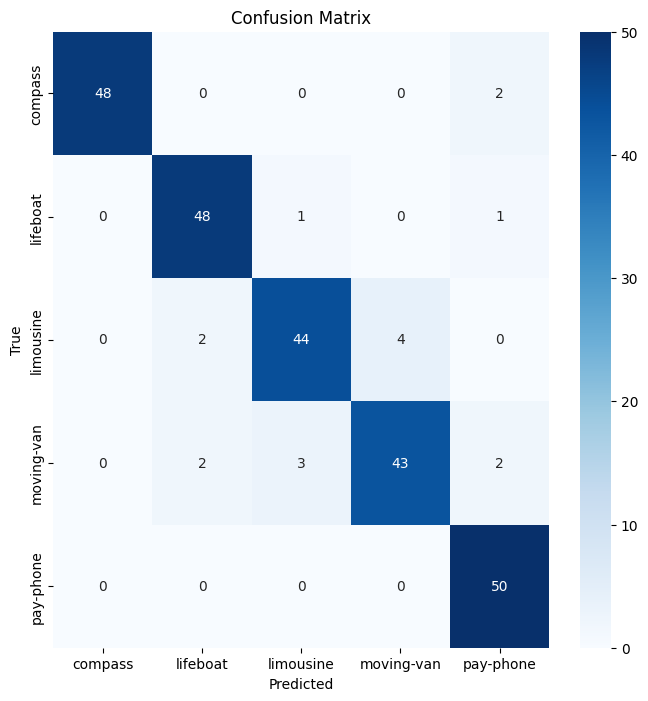

Classification Report:
              precision    recall  f1-score   support

     compass       1.00      0.96      0.98        50
    lifeboat       0.92      0.96      0.94        50
   limousine       0.92      0.88      0.90        50
  moving-van       0.91      0.86      0.89        50
   pay-phone       0.91      1.00      0.95        50

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250



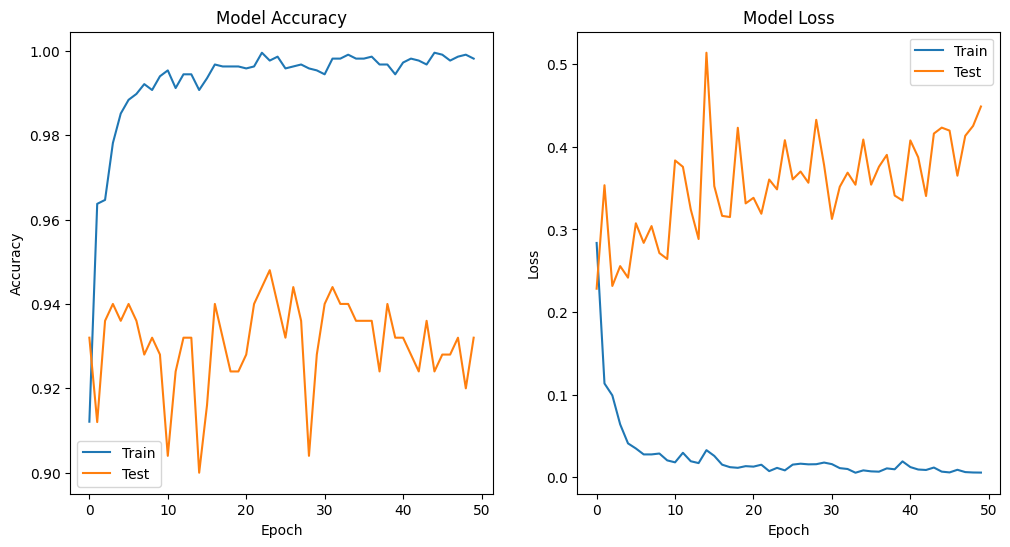


Number of Misclassified Images: 17


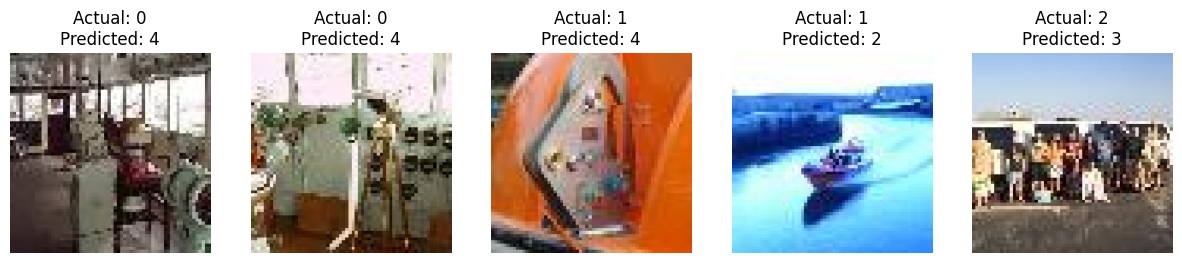

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image

from google.colab import drive



# Mount Google Drive
drive.mount('/content/drive')

# Define paths for training and testing data
path_train = '/content/drive/MyDrive/Group_4/train'
path_test = '/content/drive/MyDrive/Group_4/test'

# Image size for InceptionV3
img_size = (299, 299)

# Create ImageDataGenerator without augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data
train_generator = train_datagen.flow_from_directory(path_train, target_size=img_size, class_mode='categorical')

# Create ImageDataGenerator for testing data
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load testing data
test_generator = test_datagen.flow_from_directory(path_test, target_size=img_size, class_mode='categorical', shuffle=False)

# Define InceptionV3 model with pretrained weights
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers in the pretrained model
for layer in inception_model.layers:
    layer.trainable = False

# Add custom classification layers on top of InceptionV3
x = AveragePooling2D(pool_size=(8, 8))(inception_model.output)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

# Create the final model
inception_net = Model(inputs=inception_model.input, outputs=x)

# Compile the model
inception_net.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoints
checkpoint_filepath = '/content/drive/MyDrive/Group_4/inception_net_checkpoint.h5'
model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model without augmentation
history = inception_net.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[model_checkpoint]
)

# Load the best model
inception_net.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
test_loss, test_accuracy = inception_net.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate confusion matrix and classification report
Y_pred = inception_net.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices)

# Display confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:")
print(class_report)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Display misclassified test images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)

print(f"\nNumber of Misclassified Images: {num_misclassified}")

# Display some misclassified images along with their actual labels
plt.figure(figsize=(15, 5))
for i in range(min(5, num_misclassified)):
    index = misclassified_indices[i]
    img = image.load_img(test_generator.filepaths[index], target_size=img_size)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {test_generator.classes[index]}\nPredicted: {y_pred[index]}")
    plt.axis('off')

plt.show()
